In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np

import obspy
from obspy import read, UTCDateTime, Stream, Trace

import xarray as xr
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.signal import spectrogram as sp
from scipy.signal import welch 

import os
import sys  
module_path = os.path.abspath(os.path.join('/Users/gilaverbuch/dev/WavePropagation/pypekeris'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.pypekeris.pypekeris import pekeris, pekeris_broadband

import webbrowser 
import dask as dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar

# dask.config.set(scheduler='threads')


cluster = LocalCluster(n_workers=1, threads_per_worker=2)
client_dask = Client(cluster)
webbrowser.open(client_dask.dashboard_link, new=2)

2023-08-09 16:24:14,197 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/s6/xvzncnkj3n36krpjz97wfbnw0000gn/T/dask-worker-space/worker-a3m8hzw2', purging
2023-08-09 16:24:14,197 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/s6/xvzncnkj3n36krpjz97wfbnw0000gn/T/dask-worker-space/worker-ed580x42', purging


True

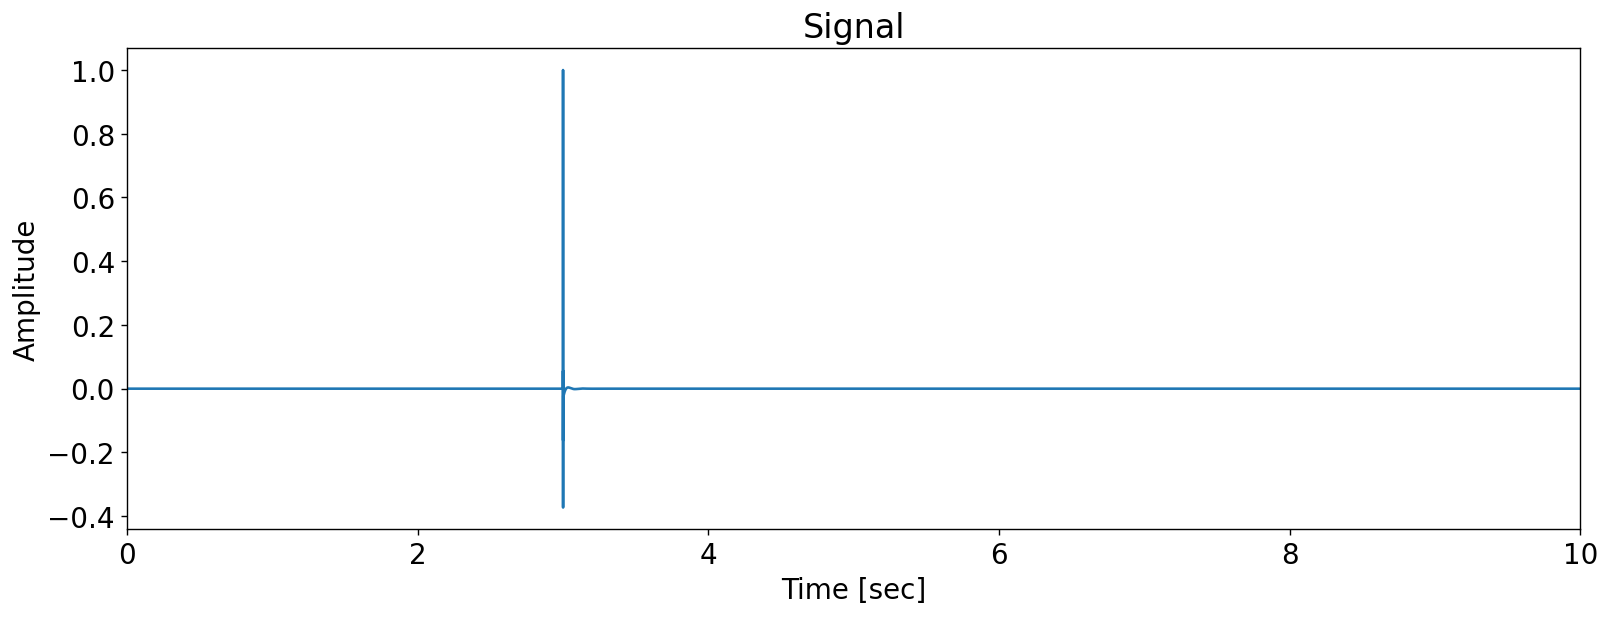

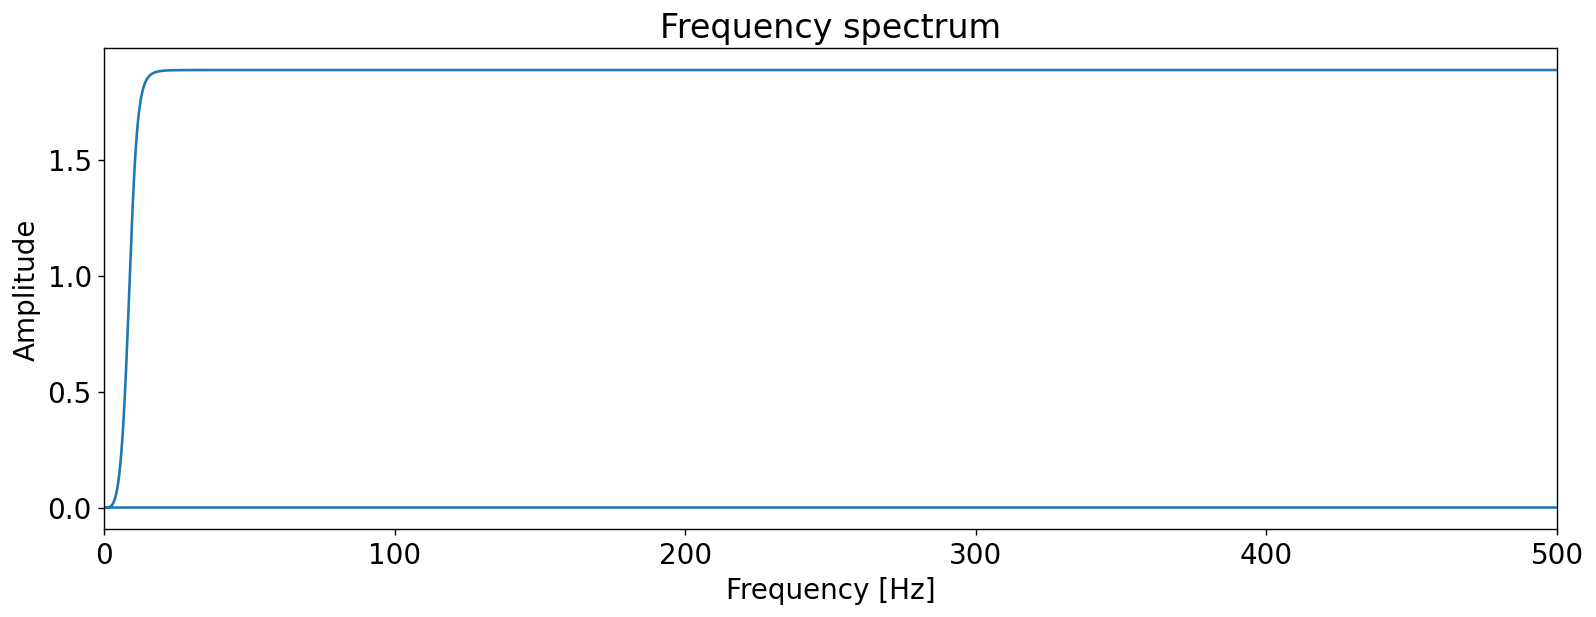

In [2]:
dt = 1e-4
l=int(50/dt)
time = np.arange(0,dt*l, dt)

fmin = 10
fmax = 3e3

t0 = 3
t0_samp = int(t0/dt)

sig_ref = np.zeros(time.size, dtype=np.float32)
sig_ref[t0_samp] = 1

tr = Trace()
tr.stats.network = 'Signal'
tr.stats.station = 'src'
tr.stats.channel = 'FDH' # 
tr.stats.starttime = UTCDateTime.now()
tr.stats.sampling_rate = 1/dt
tr.stats.delta = dt
tr.stats.npts = time.size
tr.stats.calib = 1
tr.stats.units = 'Norm.'
tr.data = sig_ref

tr.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4)

sig_ref = tr.data/np.max(tr.data)

l = len(sig_ref)
frequency = np.fft.fftfreq(l, dt)
df = frequency[1]
freq_ref = np.fft.fft(sig_ref)

plt.figure(figsize=(15,5))
plt.plot(time, sig_ref)
plt.xlim(0,10)
plt.title('Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(frequency, np.abs(freq_ref))
plt.xlim(0,500)
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.show()

In [4]:
def pekeris_broadband_(f):
    z_r = 10
    r_r = 5000
    P = pekeris(f=f, nq=5e4, dr=1, zs=5, d=50)
    P._calc_parameters()
    P._calc_field(r_rec=r_r, z_rec=z_r, num_mode=5)
    
    return P.Phi 

In [16]:
l =[]

pressure = np.zeros(frequency.size, dtype=np.complex64)
fmax_idx = int(frequency.size/2)

fmax_idx = 5000

for idx, f in enumerate(frequency[100:fmax_idx]):
    
    a = delayed(pekeris_broadband_)(f) 
    a = pekeris_broadband_(f)
    pressure[idx] = a
    l.append(a)
    
# p = compute(*l) 

In [17]:
%%time
# with ProgressBar():
#     p = compute(*l, scheduler='processes') 

p = compute(*l)

CPU times: user 29.2 ms, sys: 13 ms, total: 42.2 ms
Wall time: 35 ms


In [9]:
pressure[100:fmax_idx] = p

NameError: name 'p' is not defined

In [11]:
pressure_time = np.real(np.fft.fft(freq_ref*pressure*2))

In [12]:
r_r = 2000
T = r_r/1430
print(T)
shift_samp = int(3*T/dt)


signal = np.roll(pressure_time, shift=shift_samp)

tr_r = tr.copy()
tr_r.stats.station = 'rcv'
tr_r.data = signal


1.3986013986013985


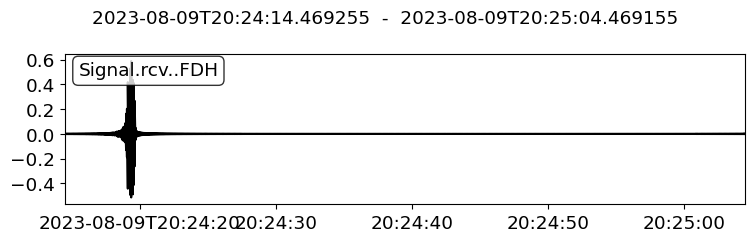

In [13]:
tr_r.plot();

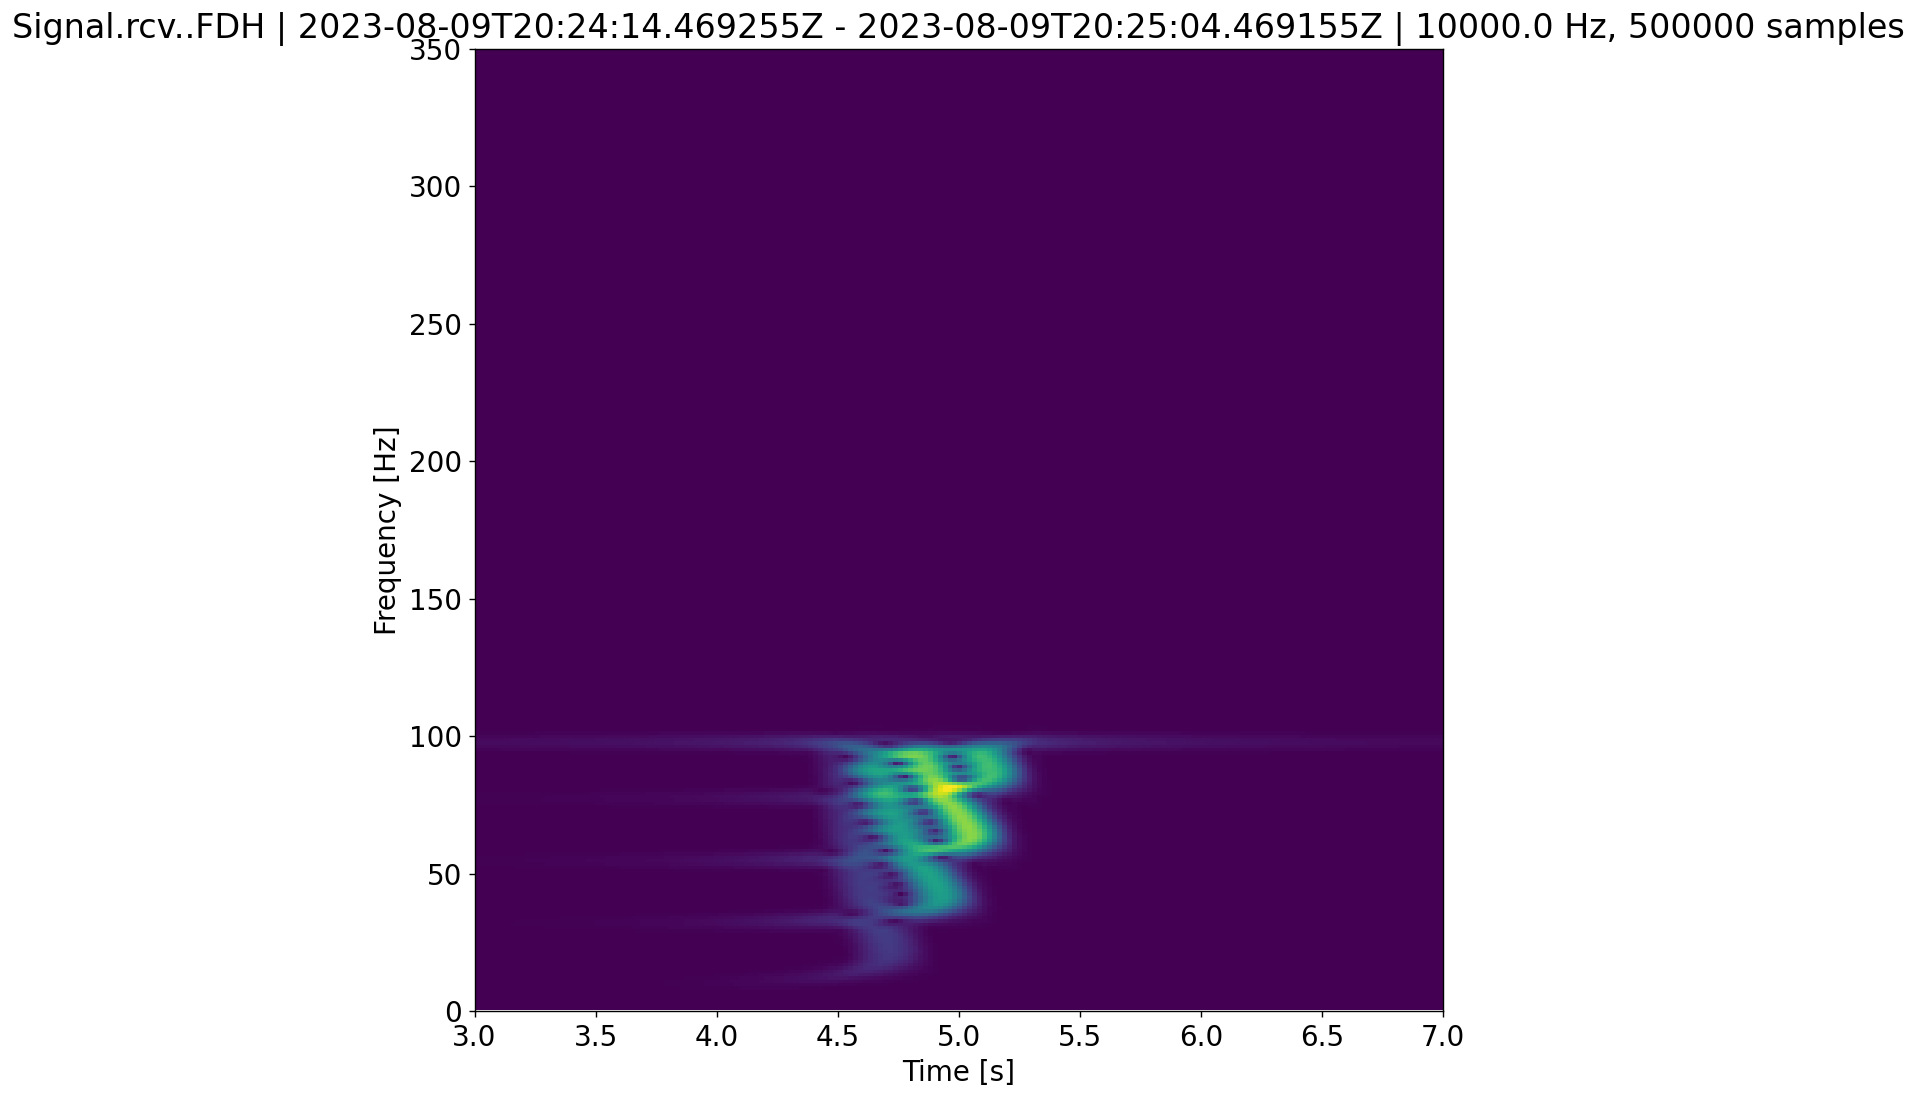

In [15]:
fig = tr_r.spectrogram(wlen=0.5, per_lap=0.95, mult=2, log=False, dbscale=False, show=False);
fig.set_figheight(10)
fig.set_figwidth(10)
plt.ylim(0,350)
plt.xlim(3,7)
plt.show()

In [ ]:
pressure = np.zeros(frequency.size, dtype=np.complex64)

z_r = 9
r_r = 10000
fmax_idx = int(frequency.size/2)
for idx, f in enumerate(tqdm(frequency[1:fmax_idx])):
    P = pekeris(f=f, nq=5e4, dr=1, zs=1, d=20)
    P._calc_parameters()
    P._calc_field(r_rec=r_r, z_rec=z_r, num_mode=3)
    pressure[idx] = P.Phi*freq_ref[idx]

In [ ]:
def pekeris_broadband(t0=3, t_max=50, fmin=1e1, fmax=1e2, dt=1e-3, zs=5, zr=5, r=1e4, d=20, num_mode=3):
    '''
    This function is based on the Pekeris class, and conputes the broadband signal in a Pekeris waveguide.
    
    parameters
    ----------
        t0 = time delay of the signal, default is 3 sec
        t_max = maximum simulation time, default is 50 sec 
        fmin = minimum frequency, default is 1e1 Hz 
        fmax = maximum frequency, default is 1e2 Hz 
        dt = time intevals, default is 1e-3 sec 
        zs = source depth, default is 5 m 
        zr = receiver depth, default is 5 m 
        r = receiver distance, default is 1e4 m
        d = waveguide depth, default is 20 m
        num_mode = number of modes to compute, default is 3
    '''
    
    l=int(t_max/dt)
    time = np.arange(0,dt*l, dt)

    t0_samp = int(t0/dt)

    sig_ref = np.zeros(time.size, dtype=np.float32)
    sig_ref[t0_samp] = 1

    tr_s = Trace()
    tr_s.stats.network = 'Signal'
    tr_s.stats.station = 'src'
    tr_s.stats.channel = 'FDH' # 
    tr_s.stats.starttime = UTCDateTime.now()
    tr_s.stats.sampling_rate = 1/dt
    tr_s.stats.delta = dt
    tr_s.stats.npts = time.size
    tr_s.stats.calib = 1
    tr_s.stats.units = 'Norm.'
    tr_s.data = sig_ref

    tr_s.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4)

    sig_ref = tr_s.data/np.max(tr_s.data)

    l = len(sig_ref)
    frequency = np.fft.fftfreq(l, dt)
    df = frequency[1]
    freq_ref = np.fft.fft(sig_ref)

    pressure = np.zeros(frequency.size, dtype=np.complex64)

    fmax_idx = int(frequency.size/2)
    for idx, f in enumerate(tqdm(frequency[1:fmax_idx])):
        P = pekeris(f=f, nq=5e4, dr=1, zs=1, d=20)
        P._calc_parameters()
        P._calc_field(r_rec=r, z_rec=zr, num_mode=num_mode)
        pressure[idx] = P.Phi*freq_ref[idx]
        
    pressure_time = np.real(np.fft.fft(freq_ref*pressure*2))
    T = r/P.c1
    shift_samp = int(T/dt)
    signal = np.roll(pressure_time, shift=shift_samp)
    
    tr_r = tr_s.copy()
    tr_r.stats.station = 'rcv'
    tr_r.data = signal

    
    return tr_s, tr_r

    

In [ ]:
pressure = np.zeros(frequency.size, dtype=np.complex64)

z_r = 9
r_r = 10000
fmax_idx = int(frequency.size/2)
for idx, f in enumerate(tqdm(frequency[1:fmax_idx])):
    P = pekeris(f=f, nq=5e4, dr=1, zs=1, d=20)
    P._calc_parameters()
    P._calc_field(r_rec=r_r, z_rec=z_r, num_mode=3)
    pressure[idx] = P.Phi*freq_ref[idx]
